# <span style="color:green">Final Project - Explainer Notebook</span>
---

This report is written in the course 02806 Social Data Analysis, spring 2017, based on the assignment description found [here](https://github.com/suneman/socialdataanalysis2017/wiki/Final-Project) for the final exam project. 

## <span style="color:green">Motivation</span>

### <span style="color:green">What is your dataset?</span>

The dataset chosen for this project is from the Public Safety section from the website of New York OpenData -- "NY Traffic Collisions". This includes data for Manhattan, Staten Island, Bronx, Queens, Brooklyn and Unknown.

### <span style="color:green">Why did you choose this/these particular dataset(s)?</span>

Going through different OpenData sources such as [London OpenData](https://data.london.gov.uk/), [SF OpenData](https://data.sfgov.org/), [European OpenData](https://open-data.europa.eu) that what seemed as a lot of different opportunities in chosing data was in fact not. A lot of the publicly available data was lacking either in size (only a few years) or extremely badly formatted, only with a few features, a lot of missing values etc. What would be nice was if there were several years (5-10) and lots of different features to chose from. This way it would be possible to take some active choices on what to keep or discard and chose what was important for predictions, basic statistics and so on.

Looking into [NYC OpenData](http://opendata.cityofnewyork.us/) and the Public Safety Category, the "Traffic Collisions" dataset was discovered. Here we get information on where in New York different traffic collisions happens, the involved parties, which type of vehicle, whether the driver was distrated/unattentive, the contributing factors, geolocations -- a great level of detail to work on and make predictions on!

In all we have $29$ features and $226.051$ different incidents from 2012 until March 24th 2017 -- the data is soo fresh!

### <span style="color:green">What was your goal for the end user's experience?</span>

## <span style="color:green">Basic stats</span>

### <span style="color:green">Libraries</span>
**Importing needed packages for entire solution**


In [3]:
import urllib2
import numpy as np
import re
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
#from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from scipy import stats, linalg
import pandas as pd
from collections import Counter 
from operator import itemgetter
import geoplotlib as gpl
from geoplotlib.utils import BoundingBox
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import pylab as pl
#from sklearn import neighbors, datasets
#from sklearn.neighbors import KNeighborsClassifier

# Plotting with plotly
import plotly 
from IPython.display import Image
# Henriettes plotly API key og brugernavn -- gemmer plots i skyen
plotly.tools.set_credentials_file(username='frksteenhoff2', api_key='duu8hsfRmuI5rF2EU8o5')
import plotly.plotly as py
import plotly.graph_objs as go

In [63]:
# Importing data using pandas
traffic_data = pd.read_csv('Traffic_data.csv', low_memory=False) # Updated 20th of February

In [12]:
#traffic_data['NUMBER OF PERSONS KILLED'].sum(axis=0)

In [4]:
# Inflicted boroughs

# Total number of collisions

# Collision per year - time series transition if possible

# Per vehicle type

### <span style="color:green">Write about your choices in data cleaning and preprocessing</span>

#### Finding relevant features

#### Reason for excluding/including features

### <span style="color:green">Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)</span>

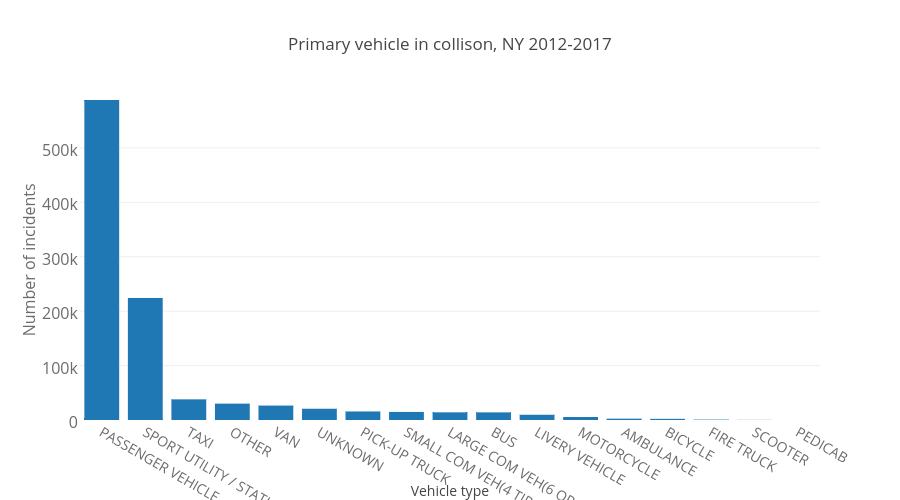

In [64]:
# Replace NaN with 'unknown'
vehicle_types = traffic_data['VEHICLE TYPE CODE 1'].replace(np.NaN, 'OTHER')

# Count number of occurences of the different categories
collision_count = Counter()
for collision in vehicle_types:
    collision_count[collision] += 1
collision_count

# Plot bar chart of vehicle types involved in collisions
labels, values = zip(*collision_count.most_common())

# Plotting color
bgBorder  = 'rgba(255, 255, 255, 0)'
ticksAxes = 'rgb(107, 107, 107)'

data = [go.Bar(
          x = labels,
          y = values
)]

# Setting layout details for plot
layout = go.Layout(
    title='Primary vehicle in collison, NY 2012-2017',
    autosize=False,
    width=900,
    height=500,

    xaxis=dict(
        title='Vehicle type',
        tickfont=dict(
            size=14,
            color=ticksAxes
        )
    ),
    
    yaxis=dict(
        range=[min(values)-1,max(values)+1],
        title='Number of incidents',
        titlefont=dict(
            size=16,
            color=ticksAxes
        ),
        tickfont=dict(
            size=16,
            color=ticksAxes
        )
    ),
    
    legend=dict(
        x=0,
        y=1.0,
        bgcolor=bgBorder,
        bordercolor=bgBorder
    )
)

fig = go.Figure(data=data, layout=layout)
py.image.save_as(fig, filename='vehicles.png')
Image('vehicles.png') # Display a static image

In [65]:
# Replace NaN with 'Unspecified'
factor_types = traffic_data['CONTRIBUTING FACTOR VEHICLE 1'].replace(np.NaN, 'Unspecified')

# Count number of occurences of the different categories
factor_count = Counter()
for factor in factor_types:
    factor_count[factor] += 1
    
# Remove unspecified in order to get a better picture of remaining entries
del factor_count['Unspecified']

# Plot bar chart of vehicle types involved in collisions
labels, values = zip(*factor_count.most_common())

# Plotting color
bgBorder  = 'rgba(255, 255, 255, 0)'
ticksAxes = 'rgb(107, 107, 107)'

data = [go.Bar(
          x = labels,
          y = values
)]

# Setting layout details for plot
layout = go.Layout(
    title='Contributing factors for collisions, NY 2012-2017',
    autosize=False,
    width=900,
    height=500,

    xaxis=dict(
        title='Reason/factor',
        tickfont=dict(
            size=14,
            color=ticksAxes
        )
    ),
    
    yaxis=dict(
        range=[min(values)-1,max(values)+1],
        title='Number of incidents',
        titlefont=dict(
            size=16,
            color=ticksAxes
        ),
        tickfont=dict(
            size=16,
            color=ticksAxes
        )
    ),
    
    legend=dict(
        x=0,
        y=1.0,
        bgcolor=bgBorder,
        bordercolor=bgBorder
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='style-bar')
#py.image.save_as(fig, filename='factors.png')
#image('factors.png') # Display a static image

In [66]:
# Most common vehicles in collision
print "Most common vehicles involved in collisions:\n", collision_count.most_common(10)
print "Most common contributing factors for collisions:\n", factor_count.most_common(10)

Most common vehicles involved in collisions:
[('PASSENGER VEHICLE', 587958), ('SPORT UTILITY / STATION WAGON', 224235), ('TAXI', 37972), ('OTHER', 30099), ('VAN', 26545), ('UNKNOWN', 20714), ('PICK-UP TRUCK', 15714), ('SMALL COM VEH(4 TIRES) ', 14874), ('LARGE COM VEH(6 OR MORE TIRES)', 14117), ('BUS', 14020)]
Most common contributing factors for collisions:
[('Driver Inattention/Distraction', 131423), ('Fatigued/Drowsy', 48266), ('Failure to Yield Right-of-Way', 44060), ('Other Vehicular', 30815), ('Backing Unsafely', 28718), ('Turning Improperly', 24227), ('Lost Consciousness', 20092), ('Prescription Medication', 15890), ('Traffic Control Disregarded', 12533), ('Driver Inexperience', 12171)]


### Plotting the collisions per year
Consider removing data from 2017, since the data is not complete.

C:\Users\frksteenhoff\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



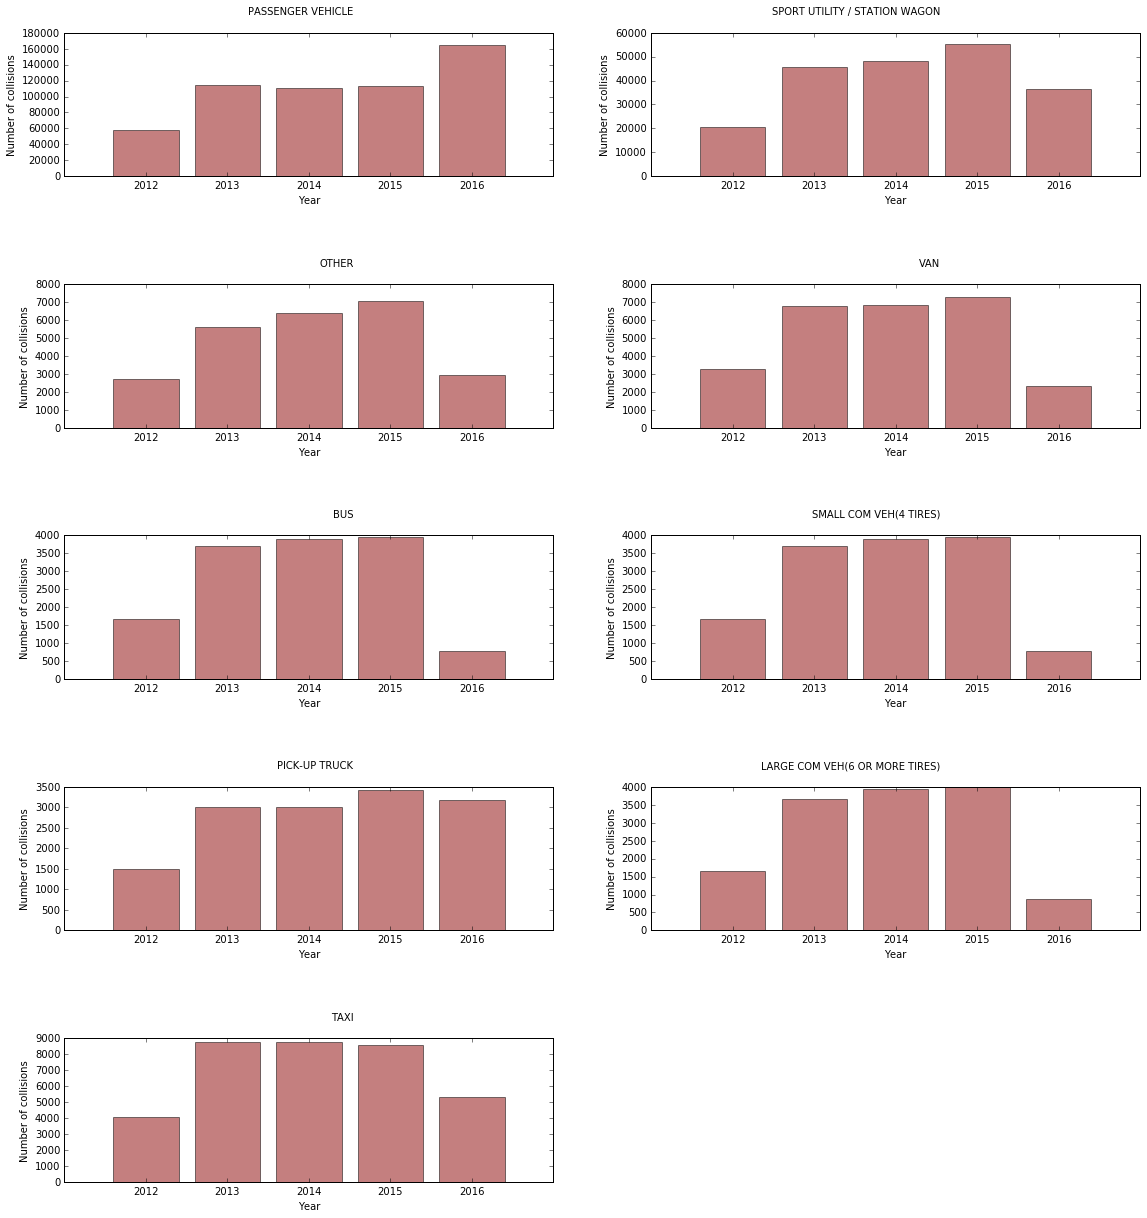

In [67]:
# Create 2 X 5 grid for the 10 collision subplots
# Initialize variables
vehicle_types = ['PASSENGER VEHICLE', 'SPORT UTILITY / STATION WAGON',
                 'OTHER','VAN','BUS','SMALL COM VEH(4 TIRES)', 
                 'PICK-UP TRUCK', 'LARGE COM VEH(6 OR MORE TIRES)', 'TAXI']
y_cnt = Counter()
temp_vehicle_y = []
plotVar = 1 # plotting variable, keeps track of subplot

# Run through each vehicle type
for vehicle in vehicle_types:
    # Make data structure with one collision category at a time
    temp_values = traffic_data.loc[traffic_data['VEHICLE TYPE CODE 1'].isin([vehicle])]
    # Add column with year
    temp_values['YEAR'] = pd.to_datetime(temp_values['DATE']).dt.year
    for year in list(set(temp_values['YEAR'])):
        # Add number of collisions for each year to dict
        if year != np.int64(2017):
            y_cnt[year] = len(temp_values.loc[temp_values['YEAR'].isin([year])])
    
    # Sort plot values
    labels, values = zip(*sorted(y_cnt.items()))
    indexes = np.arange(len(labels))
    
    # Add plot variables
    plt.subplot(5, 2, plotVar)
    plt.annotate(vehicle, xy=(1, 0), xycoords='axes fraction',
                 xytext=(-200, 160), textcoords='offset pixels',
                 horizontalalignment='right',verticalalignment='bottom') # Labels on each plot
    plt.bar(indexes, values, align='center', alpha=0.5, color='darkred')
    
    # Plot the results
    plt.xticks(indexes, labels)
    plt.ylabel('Number of collisions')
    plt.xlabel('Year')
    plt.subplots_adjust(bottom=.01, left=.01, right=2.5, top=4.0, hspace=.75)
    plotVar += 1

plt.show()


### Read New York Demographcs data

In [68]:
ny_demographics = pd.read_excel('NY_demographics.xlsx')
ny_demographics

,borough,population,sqMi,sqKm,personsPerSqMi,personsPrSqKm
0,Manhattan,1644518,22.83,59.1,72033.00,27826
1,Bronx,1455444,42.00,110.0,34653.00,13231
2,Brooklyn,2636735,71.00,180.0,37137.00,14649
3,Queens,2339150,109.00,280.0,21.46,8354
4,Staten Island,474558,58.50,152.0,8112.00,3132


In [71]:
len(traffic_data.loc[traffic_data['YEAR'].isin([np.int64('2016')])])

227658

In [101]:
def createBarPlot(valueDict, plotTitle, xLabel, yLabel, fileName):
    # Plot bar chart of vehicle types involved in collisions
    labels, values = zip(*valueDict.most_common(5))

    # Plotting color
    bgBorder  = 'rgba(255, 255, 255, 0)'
    ticksAxes = 'rgb(107, 107, 107)'

    data = [go.Bar(
              x = labels,
              y = values
    )]

    # Setting layout details for plot
    layout = go.Layout(
        title=plotTitle,
        autosize=False,
        width=900,
        height=500,

        xaxis=dict(
            title=xLabel,
            tickfont=dict(
                size=14,
                color=ticksAxes
            )
        ),

        yaxis=dict(
            range=[min(values)-1,max(values)+1],
            title=yLabel,
            titlefont=dict(
                size=16,
                color=ticksAxes
            ),
            tickfont=dict(
                size=16,
                color=ticksAxes
            )
        ),

        legend=dict(
            x=0,
            y=1.0,
            bgcolor=bgBorder,
            bordercolor=bgBorder
        )
    )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename=(fileName+'.png'))
    #py.image.save_as(fig, filename='factors.png')
    #image('factors.png') # Display a static image

In [104]:
# Get subset of traffic data values
def getValuesFromDataFrame(dataFrame, feature, listOfValues):
    data = dataFrame.loc[dataFrame[feature].isin(listOfValues)]
    return data

In [105]:
# Count values in dataframe for plotting
def countValuesInDataFrame(dataFrame, feature):
    val_cnt = {}
    for val in list(set(dataFrame[feature])):
        val_cnt[val] = len(dataFrame.loc[dataFrame[feature].isin([val])])
    return val_cnt

In [106]:
# Create yearly overview of collisions in each borough
year_view = getValuesFromTrafficData(traffic_data, 'YEAR', ['BOROUGH'])
#year view = year_view.loc[year_view['']]
borough_cnt = countValuesInDataFrame(year_view, 'BOROUGH')
print borough_cnt
createBarPlot(borough_cnt, 'Collisions per borough in 2016', 'Borough', 'Number of collisions', 'collisions_2016')

{}


AttributeError: 'dict' object has no attribute 'most_common'

In [100]:
borough_cnt.values()

[]

## <span style="color:green">Theory - theoretical tools</span>

### <span style="color:green">Describe which machine learning tools you use and why the tools you've chosen are right for the problem you're solving.</span>


### <span style="color:green">Talk about your model selection. How did you split the data in to test/training. Did you use cross validation?</span>

### <span style="color:green">Explain the model performance. How did you measure it? Are your results what you expected?</span>

## <span style="color:green">Visualizations</span>

### <span style="color:green">Explain the visualizations you've chosen.</span>

### <span style="color:green">Why are they right for the story you want to tell?</span>

## <span style="color:green">Discussion - critical thinking</span>


### <span style="color:green">What went well?</span>


### <span style="color:green">What is still missing? What could be improved?, Why?</span>